In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
import hashlib
from collections import defaultdict
from itertools import combinations


In [2]:
file  = np.load('user_movie_rating.npy')
user_id = file[:,0]
movie_id = file[:,1]
rating = file[:,2]

count_ones = np.sum(user_id == 1)
count_twos = np.sum(user_id == 2)
print(count_ones)

similarity_threshold = 0.5
print(len(movie_id))
print(movie_id[count_ones+count_twos-1:])
print(file)

626
65225506
[17764    30    84 ... 17622 17627 17764]
[[     1     30      3]
 [     1    157      3]
 [     1    173      4]
 ...
 [103703  17622      2]
 [103703  17627      4]
 [103703  17764      4]]


In [3]:
#create a sparse matrix of the user-movie rating, where the movies that recieved a rating get a 1 and the ones that did not get a rating get a 0
#We assume from the assignment that we only care about movies that were rated but not the actual ratings. Thus giving a binary matrix

def create_matrix(file):
    user_id = file[:,0]
    movie_id = file[:,1]
    rating = file[:,2]
    data = np.ones(len(rating))
    user_movie_matrix = csc_matrix((data, (movie_id, user_id))) #heb movie en user omgedraaid, omdat we de users als colommen willen hebben
    return user_movie_matrix

In [4]:
user_movie_matrix = create_matrix(file)
#delete the first row and column since they are empty
user_movie_matrix = user_movie_matrix[1:,1:]
# print(user_movie_matrix)
# print(user_movie_matrix.shape)

print(user_movie_matrix.toarray()[27:31,0:3]) #to see the axes of the matrix

[[0. 1. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


Note: Ik heb nu de binary matrix getransposed om de de users als kolommen en movies als rijen willen.

In [5]:
#make a minhash function for the csc matrix, I realise now that a csr matrix might have been more efficient
def minhash(data, num_permutations):
    if not isinstance(data, csc_matrix):
        raise ValueError("Input data must be a scipy.sparse CSC matrix.")
    
    num_movies = data.shape[1]  # Number of columns (features)
    num_users = data.shape[0]   # Number of rows (samples)
    
    # Create random permutations
    permutations = [np.random.permutation(num_movies) for _ in range(num_permutations)]
    perm_signature = np.full((num_users, num_permutations), np.inf)
    
    # Iterate over columns (movies/features) of the CSC matrix
    for movie_index in range(num_movies):
        # Get all non-zero row indices for the current column
        row_indices = data.indices[data.indptr[movie_index]:data.indptr[movie_index + 1]]
        
        for k in range(num_permutations):
            # Compute the hash value for the current column (movie_index)
            hash_value = permutations[k][movie_index]
            
            # Update the MinHash signature for the rows with non-zero values in this column
            for row_index in row_indices:
                perm_signature[row_index, k] = min(perm_signature[row_index, k], hash_value)

    return perm_signature#.transpose()



In [6]:
#testhash = minhash(user_movie_matrix, 100)

# #save the minhash signature to a file
#np.save('minhash_transposed.npy', testhash)
testhash = np.load('minhash_transposed.npy')
print(testhash)
print(testhash.shape)


[[2.430e+02 6.200e+01 6.200e+01 ... 6.480e+02 1.070e+02 6.190e+02]
 [9.320e+02 2.167e+03 6.200e+01 ... 2.658e+03 1.209e+03 1.688e+03]
 [9.000e+01 9.000e+00 2.000e+00 ... 1.500e+01 1.200e+01 3.300e+01]
 ...
 [1.800e+02 1.030e+02 1.040e+02 ... 6.700e+01 4.500e+01 1.740e+02]
 [6.000e+00 2.500e+01 1.100e+01 ... 5.500e+01 3.000e+01 5.900e+01]
 [5.200e+01 4.330e+02 2.940e+02 ... 2.200e+01 1.700e+02 1.980e+02]]
(17770, 100)


[[2.430e+02 6.200e+01 6.200e+01 ... 6.480e+02 1.070e+02 6.190e+02]
 [9.320e+02 2.167e+03 6.200e+01 ... 2.658e+03 1.209e+03 1.688e+03]
 [9.000e+01 9.000e+00 2.000e+00 ... 1.500e+01 1.200e+01 3.300e+01]
 ...
 [1.800e+02 1.030e+02 1.040e+02 ... 6.700e+01 4.500e+01 1.740e+02]
 [6.000e+00 2.500e+01 1.100e+01 ... 5.500e+01 3.000e+01 5.900e+01]
 [5.200e+01 4.330e+02 2.940e+02 ... 2.200e+01 1.700e+02 1.980e+02]]
(17770, 100)
<class 'numpy.ndarray'>


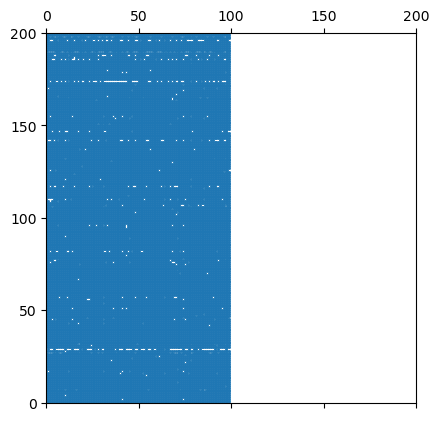

In [7]:
print(testhash)
print(testhash.shape)
print(type(testhash))
#show that the matrix has 100 columns and 17770 rows as i always forget which is which lol
#meaning columns are the users and rows are the permutations
#the rows typically refer to the first axis (axis 0), and the columns refer to the second axis (axis 1). 

plt.spy(testhash, markersize=1)
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.show()

In [8]:
#print the first colum from the user_movie_matrix, so for the first person
print(user_movie_matrix[0,:])
print(testhash[:,0])

  (0, 94)	1.0
  (0, 154)	1.0
  (0, 440)	1.0
  (0, 574)	1.0
  (0, 852)	1.0
  (0, 1188)	1.0
  (0, 1214)	1.0
  (0, 1263)	1.0
  (0, 1498)	1.0
  (0, 1716)	1.0
  (0, 1717)	1.0
  (0, 1802)	1.0
  (0, 2180)	1.0
  (0, 2325)	1.0
  (0, 2680)	1.0
  (0, 3399)	1.0
  (0, 3669)	1.0
  (0, 3689)	1.0
  (0, 3880)	1.0
  (0, 4755)	1.0
  (0, 4798)	1.0
  (0, 5267)	1.0
  (0, 5690)	1.0
  (0, 5883)	1.0
  (0, 6741)	1.0
  :	:
  (0, 95125)	1.0
  (0, 95685)	1.0
  (0, 95929)	1.0
  (0, 96450)	1.0
  (0, 96500)	1.0
  (0, 96768)	1.0
  (0, 96896)	1.0
  (0, 97743)	1.0
  (0, 98190)	1.0
  (0, 98976)	1.0
  (0, 99285)	1.0
  (0, 99550)	1.0
  (0, 99972)	1.0
  (0, 100323)	1.0
  (0, 100326)	1.0
  (0, 100347)	1.0
  (0, 101095)	1.0
  (0, 101297)	1.0
  (0, 101363)	1.0
  (0, 102016)	1.0
  (0, 102924)	1.0
  (0, 102940)	1.0
  (0, 102994)	1.0
  (0, 103156)	1.0
  (0, 103629)	1.0
[243. 932.  90. ... 180.   6.  52.]


In [ ]:
def jaccard_similarity(signature1, signature2):
    return np.sum(signature1 == signature2) / np.sum(signature1 != np.inf)

# def lsh(signatures, num_hashes, similarity_threshold):
#     num_bands = 50
#     band_size = num_hashes // num_bands

#     buckets = {}
#     for user_id, signature in enumerate(signatures):
#         for band in range(num_bands):
#             band_hash = tuple(signature[band * band_size:(band + 1) * band_size])
#             if band_hash not in buckets:
#                 buckets[band_hash] = []
#             buckets[band_hash].append(user_id)
    
#     print(f'Amount of buckets: {len(buckets)}')
    
#     candidate_pairs = set()
#     for bucket_users in buckets.values():
#         for i in range(len(bucket_users)):
#             for j in range(i + 1, len(bucket_users)):
#                 candidate_pairs.add((bucket_users[i], bucket_users[j]))
    
#     print(f'Candidate pairs: {len(candidate_pairs)}')
    
#     similar_users = []
#     for user1, user2 in candidate_pairs:
#         if user1 == user2:
#             continue
#         sim = jaccard_similarity(signatures[user1], signatures[user2])
#         if sim >= similarity_threshold:
#             similar_users.append((user1, user2))
    
#     print(f'Similar users: {len(similar_users)}')
#     return similar_users

In [ ]:
# def hash_with_hashlib(row, num_buckets):
#     # Convert row to a string representation
#     row_str = ",".join(map(str, row))
#     # Hash the string using hashlib
#     hash_object = hashlib.sha256(row_str.encode())
#     # Convert hash to an integer
#     hash_int = int(hash_object.hexdigest(), 16)
#     # Map to a bucket
#     return hash_int % num_buckets

# def LocalSH(signatures, num_bands, num_buckets, similarity_threshold):
#     #first we split the matrix into bands , we need to make sure that the number of bands times the number of rows per band is equal to the number of rows in the signature matrix
#     if signatures.shape[1] % num_bands != 0:
#         raise ValueError("The number of columns must be divisible by m for exact band splitting.")

#     bands = np.split(signatures, num_bands, axis=1) #split the signature array along the second axis (colums)
#     print(f'# values in each band: {bands[0].shape[1]}')

#     #we will use hashlib to get a unique hash for each band

#     bucket_table = []
#     for band in enumerate(bands):
#         buckets = defaultdict(list)

#         for i, row in enumerate(band):
#             bucket = hash_with_hashlib(band, num_buckets)
#             buckets[bucket].append(i)
#         bucket_table.append(buckets)
#         #this should give us a table with the buckets for each band
#     for bucket, rows in bucket_table[0].items():
#         print(f'Bucket {bucket}: {rows}')





In [11]:
def split_vector(signature, num_bands):
    column_size = signature.shape[0] // num_bands
    #validate that the number of columns is divisible by the number of bands
    if signature.shape[1] % num_bands != 0:
        raise ValueError(f"The number of columns {signature.shape[0]} must be divisible by the number of bands {num_bands} for exact band splitting.")
    split_arrays = np.hsplit(signature, signature.shape[0]//column_size)
    print([sub_array.shape for sub_array in split_arrays])
    return split_arrays

def Hash_band(column, num_buckets):
    #convert the 20 values to a string
    column_str = ",".join(map(str, column))
    return hash(column_str) % num_buckets


In [12]:
testhash.shape[1]

100

In [13]:
split_arrays = split_vector(testhash, 5)
split_arrays[0]


[(17770, 20), (17770, 20), (17770, 20), (17770, 20), (17770, 20)]


array([[2.430e+02, 6.200e+01, 6.200e+01, ..., 9.340e+02, 2.720e+02,
        2.080e+02],
       [9.320e+02, 2.167e+03, 6.200e+01, ..., 6.710e+02, 5.190e+02,
        3.512e+03],
       [9.000e+01, 9.000e+00, 2.000e+00, ..., 8.000e+00, 8.000e+00,
        2.400e+01],
       ...,
       [1.800e+02, 1.030e+02, 1.040e+02, ..., 2.730e+02, 9.000e+00,
        2.400e+01],
       [6.000e+00, 2.500e+01, 1.100e+01, ..., 2.200e+01, 1.300e+01,
        4.400e+01],
       [5.200e+01, 4.330e+02, 2.940e+02, ..., 1.350e+02, 8.840e+02,
        3.970e+02]])

In [14]:
hashbucketdict = {}


for i in range(len(split_arrays)):
    hashbucketdict[f'hash{i}'] = np.apply_along_axis(Hash_band, 1, split_arrays[i], num_buckets=17770)



(array([6., 1., 2., ..., 0., 0., 2.]),
 array([0.00000000e+00, 9.99943725e-01, 1.99988745e+00, ...,
        1.77670001e+04, 1.77680001e+04, 1.77690000e+04]),
 <BarContainer object of 17770 artists>)

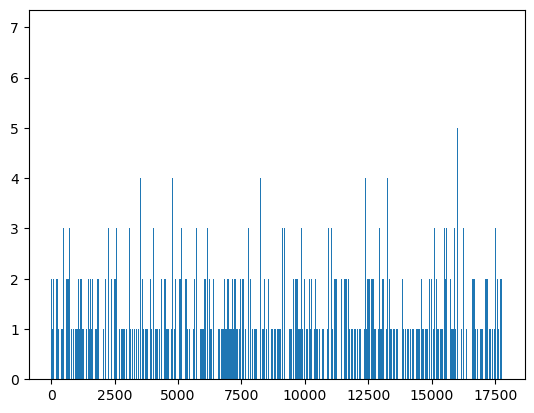

In [ ]:
plt.hist(hashbucketdict['hash0'], bins=17770)



In [39]:
for i in range(len(split_arrays)):
    print(len(hashbucketdict[f'hash{i}']))

17770
17770
17770
17770
17770


In [ ]:
#alleen voor test van sepcifieke hashbucket

#create a dictionary to group indices by bucket values
bucket_groups = defaultdict(list)

#populate the dictionary

for idx, bucket in enumerate(hashbucketdict['hash0']):

    bucket_groups[bucket].append(idx)

filtered_buckets = {bucket: indices for bucket, indices in bucket_groups.items() if len(indices) > 1 if len(indices) < 3} #if you want buckets with more than 2 values then remove the second if statement


In [21]:
filtered_buckets

{7693: [0, 6121],
 6851: [1, 4335],
 1156: [3, 17172],
 10630: [5, 1497],
 1519: [6, 6068],
 7492: [7, 16053],
 5240: [9, 7469],
 8248: [11, 3384],
 13487: [15, 6109],
 9954: [17, 14246],
 1868: [18, 7766],
 12074: [19, 14453],
 12539: [21, 5877],
 1204: [22, 2360],
 3181: [23, 2675],
 14174: [27, 14038],
 12813: [28, 16399],
 15764: [30, 4749],
 5171: [40, 3423],
 1950: [41, 13734],
 4766: [43, 11723],
 11652: [45, 16426],
 9263: [46, 5737],
 16431: [60, 16997],
 17267: [63, 11268],
 11278: [64, 15354],
 2123: [66, 459],
 5578: [67, 4696],
 4852: [68, 643],
 4384: [69, 7721],
 1386: [71, 12414],
 11249: [74, 431],
 7677: [78, 6634],
 7578: [80, 5377],
 9453: [83, 4594],
 6836: [88, 1626],
 5439: [94, 14162],
 8454: [95, 15977],
 1812: [98, 4694],
 6451: [99, 13568],
 5438: [101, 5560],
 10627: [102, 14861],
 13994: [103, 6548],
 5464: [107, 8015],
 10710: [111, 12233],
 7312: [112, 6013],
 11924: [113, 6210],
 11918: [118, 4305],
 11697: [120, 17500],
 4133: [123, 16890],
 1033: [131,

In [32]:
total_indices = sum((len(indices) for indices in filtered_buckets.values()))
total_indices

len(testhash[1440,:])

100

In [36]:
jaccard_similarity_dict = {}
for bucket, indices in filtered_buckets.items():
    print(f'Bucket {bucket}: {indices[0]} and {indices[1]}')
    similarity = jaccard_similarity(testhash[indices[0],:], testhash[indices[1],:])
    if similarity > 0:
        jaccard_similarity_dict[f'users: {indices[0]}, {indices[1]}'] = similarity


Bucket 7693: 0 and 6121
Bucket 6851: 1 and 4335
Bucket 1156: 3 and 17172
Bucket 10630: 5 and 1497
Bucket 1519: 6 and 6068
Bucket 7492: 7 and 16053
Bucket 5240: 9 and 7469
Bucket 8248: 11 and 3384
Bucket 13487: 15 and 6109
Bucket 9954: 17 and 14246
Bucket 1868: 18 and 7766
Bucket 12074: 19 and 14453
Bucket 12539: 21 and 5877
Bucket 1204: 22 and 2360
Bucket 3181: 23 and 2675
Bucket 14174: 27 and 14038
Bucket 12813: 28 and 16399
Bucket 15764: 30 and 4749
Bucket 5171: 40 and 3423
Bucket 1950: 41 and 13734
Bucket 4766: 43 and 11723
Bucket 11652: 45 and 16426
Bucket 9263: 46 and 5737
Bucket 16431: 60 and 16997
Bucket 17267: 63 and 11268
Bucket 11278: 64 and 15354
Bucket 2123: 66 and 459
Bucket 5578: 67 and 4696
Bucket 4852: 68 and 643
Bucket 4384: 69 and 7721
Bucket 1386: 71 and 12414
Bucket 11249: 74 and 431
Bucket 7677: 78 and 6634
Bucket 7578: 80 and 5377
Bucket 9453: 83 and 4594
Bucket 6836: 88 and 1626
Bucket 5439: 94 and 14162
Bucket 8454: 95 and 15977
Bucket 1812: 98 and 4694
Bucket 6

In [37]:
len(jaccard_similarity_dict)

1031

In [38]:
jaccard_similarity_dict

{'users: 15, 6109': 0.03,
 'users: 17, 14246': 0.02,
 'users: 18, 7766': 0.01,
 'users: 21, 5877': 0.02,
 'users: 23, 2675': 0.02,
 'users: 27, 14038': 0.16,
 'users: 40, 3423': 0.02,
 'users: 43, 11723': 0.11,
 'users: 46, 5737': 0.01,
 'users: 66, 459': 0.01,
 'users: 67, 4696': 0.02,
 'users: 71, 12414': 0.03,
 'users: 78, 6634': 0.06,
 'users: 83, 4594': 0.04,
 'users: 107, 8015': 0.11,
 'users: 111, 12233': 0.04,
 'users: 112, 6013': 0.01,
 'users: 120, 17500': 0.01,
 'users: 131, 2846': 0.01,
 'users: 137, 11574': 0.01,
 'users: 154, 6427': 0.04,
 'users: 160, 373': 0.01,
 'users: 164, 12179': 0.02,
 'users: 170, 7364': 0.01,
 'users: 184, 16977': 0.09,
 'users: 188, 14869': 0.08,
 'users: 198, 3028': 0.01,
 'users: 201, 16417': 0.01,
 'users: 205, 8906': 0.01,
 'users: 240, 2092': 0.01,
 'users: 252, 16106': 0.07,
 'users: 256, 6954': 0.01,
 'users: 276, 1350': 0.02,
 'users: 284, 10230': 0.07,
 'users: 286, 10653': 0.01,
 'users: 298, 16235': 0.29,
 'users: 308, 1164': 0.01,
 '

In [ ]:
def LSH(signature, num_bands, num_buckets, similarity_threshold):
    split_arrays = split_vector(signature, num_bands)

    hashbucketdict = {}

    for i in range(len(split_arrays)):
        hashbucketdict[f'hash{i}'] = np.apply_along_axis(Hash_band, 1, split_arrays[i], num_buckets=num_buckets)
    
    bucket_groups = defaultdict(list)

    #populate the dictionary with the entire hashbucketdict

    for i in range(len(split_arrays)):
        for idx, bucket in enumerate(hashbucketdict[f'hash{i}']):
            bucket_groups[bucket].append(idx)
    filtered_buckets = {bucket: indices for bucket, indices in bucket_groups.items() if len(indices) > 1 }
    print(len(filtered_buckets))

    jaccard_similarity_dict = {}
    for bucket, indices in filtered_buckets.items():
        for set1, set2 in combinations(indices, 2):
            similarity = jaccard_similarity(signature[set1,:], signature[set2,:])
            if similarity > similarity_threshold:
                jaccard_similarity_dict[f'users: {set1}, {set2}'] = similarity

    return jaccard_similarity_dict


In [53]:
jaccard_dict = LSH(testhash, 10, 17770, 0.5)

[(17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10)]
17756
17769


In [55]:
len(jaccard_dict)

1194